# Determining constants for the Leishman-Beddoes dynamic stall model

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

In [42]:
# Function for loading data
def load():
    alpha = []
    cl = []
    cd = []
    with open("data/NACA0021.dat") as f:
        for line in f.readlines():
            if line.strip()[:2] == "//":
                pass
            else:
                line = line.replace("(", "")
                line = line.replace(")", "")
                line = line.split()
                alpha.append(float(line[0]))
                cl.append(float(line[1]))
                cd.append(float(line[2]))
    df = pd.DataFrame()
    df["alpha_deg"] = np.asarray(alpha)
    df["alpha_rad"] = df.alpha_deg/180.0*np.pi
    df["cl"] = np.asarray(cl)
    df["cd"] = np.asarray(cd)
    df["cn"] = df.cl*np.cos(df.alpha_rad) - df.cd*np.sin(df.alpha_rad)
    df["ct"] = df.cl*np.sin(df.alpha_rad) - df.cd*np.cos(df.alpha_rad)
    return df

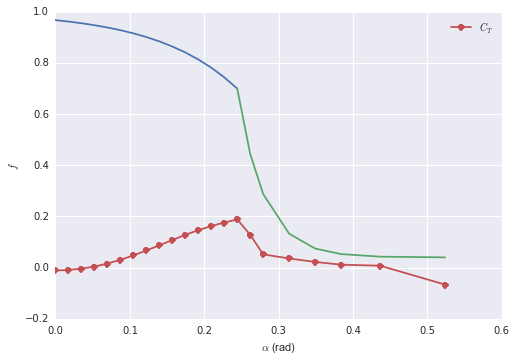

In [78]:
df = load()

# Calculate normal force slope
cn_alpha = (df.cn[df.alpha_deg==2.0].iloc[0] - df.cn[df.alpha_deg==0.0].iloc[0])/(2.0/180.0*np.pi)

# Find static stall angle
d_cd_d_alpha = np.diff(df.cd)/np.diff(df.alpha_deg)
n = np.where(d_cd_d_alpha > 0.02)[0]
alpha_ss = df.alpha_deg[n]
alpha_ss = alpha_ss[alpha_ss > 0].iloc[0]

# Find critical normal force coefficient
fcrit = 0.7
alpha1 = alpha_ss/180.0*np.pi
cn1 = cn_alpha*alpha1*((1 + np.sqrt(fcrit))/2.0)**2

# Put in some values for s1 and s2 (from turbinesFoam)
s1 = 0.109504058813
s2 = 0.0355536753234

ind = np.logical_and(df.alpha_deg >=0, df.alpha_deg <= 30)
alpha = df.alpha_rad[ind]
alpha_low = alpha[alpha <= alpha1]
alpha_high = alpha[alpha >= alpha1]
f_low = 1.0 - 0.3*np.exp((alpha_low - alpha1)/s1)
f_high = 0.04 + 0.66*np.exp((alpha1 - alpha_high)/s2)

plt.plot(alpha_low, f_low)
plt.plot(alpha_high, f_high)
plt.plot(alpha, df.ct[ind], "-o", label=r"$C_T$")
plt.xlabel(r"$\alpha$ (rad)")
plt.ylabel("$f$")
plt.legend(loc="best")
plt.savefig("figures/f.pdf")
plt.show()